In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import os
import sys
from pathlib import Path
from tqdm import tqdm

from scipy.stats import boxcox

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

ERA_DATA_PATH = str(HOME / 'system_tests/data/ERA5')



(array([3.929e+03, 4.790e+02, 3.300e+02, 2.490e+02, 2.100e+02, 2.010e+02,
        1.590e+02, 1.400e+02, 1.210e+02, 1.260e+02, 1.180e+02, 9.800e+01,
        9.200e+01, 9.100e+01, 1.060e+02, 1.060e+02, 7.400e+01, 7.900e+01,
        9.800e+01, 8.700e+01, 6.900e+01, 6.700e+01, 5.800e+01, 5.500e+01,
        5.600e+01, 6.100e+01, 4.400e+01, 5.100e+01, 6.300e+01, 4.200e+01,
        4.500e+01, 5.000e+01, 4.900e+01, 3.200e+01, 5.100e+01, 2.800e+01,
        3.500e+01, 4.200e+01, 4.700e+01, 4.100e+01, 4.200e+01, 2.700e+01,
        4.200e+01, 3.300e+01, 3.200e+01, 3.100e+01, 4.000e+01, 1.800e+01,
        2.700e+01, 2.000e+01, 2.700e+01, 2.600e+01, 3.100e+01, 1.800e+01,
        2.500e+01, 2.300e+01, 3.000e+01, 1.800e+01, 1.600e+01, 2.200e+01,
        1.100e+01, 1.900e+01, 1.700e+01, 1.800e+01, 1.800e+01, 1.200e+01,
        1.500e+01, 1.000e+01, 2.200e+01, 1.400e+01, 6.000e+00, 1.300e+01,
        8.000e+00, 6.000e+00, 8.000e+00, 1.300e+01, 8.000e+00, 1.000e+01,
        1.000e+01, 1.000e+01, 1.200e+0

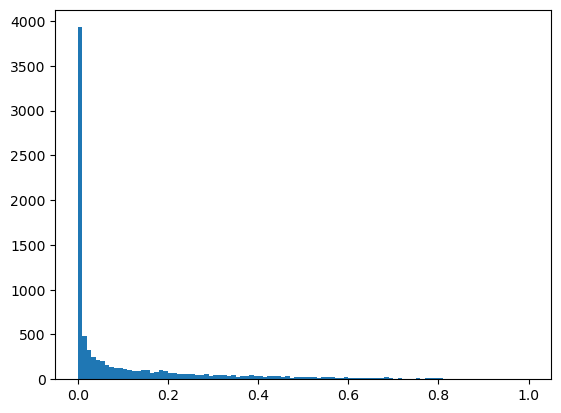

In [4]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

window_size = 20
threshold=0.1
with open(f'../fss_stats/fractions_{window_size}_{threshold}.pkl', 'rb') as ifh:
    fss_stats = pickle.load(ifh)

(n_samples, lat_length, lon_length) = fss_stats.shape

lat_index = random.choice(range(lat_length))
lon_index = random.choice(range(lon_length))

data = fss_stats[:, lat_index, lon_index]
plt.hist(data, bins=100)

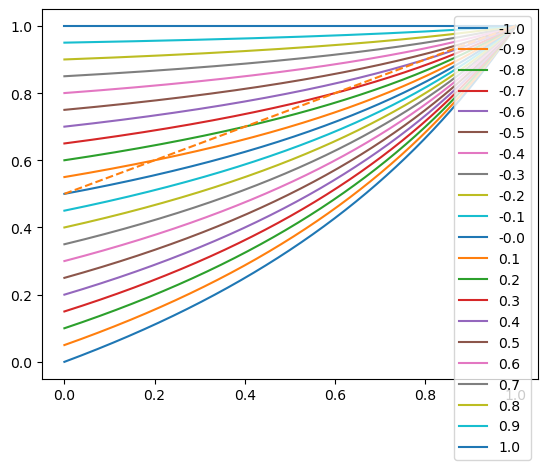

In [6]:
p = np.arange(0,1,0.001)

rho_vals = np.arange(-1, 1.1, 0.1)
c_vals = np.arange(1,50)

def fss(p, rho):
    fss_original = 0.5 + (p/2)*(1/(2-p))
    fss = fss_original + rho*(1-p)/(2-p)
    return fss, fss_original



fss_dict = {n: [fss(item, rho_vals[n])[0] for item in p] for n in range(len(rho_vals))}
fss_dict_with_c = {n: [fss(item, c_vals[n])[0] for item in p] for n in range(len(c_vals))}

for n, fss_vals in fss_dict.items():
    plt.plot(p, fss_vals, label=f'{rho_vals[n]:.1f}')
plt.plot(p, [0.5 + item/2 for item in p], '--') 
plt.legend()

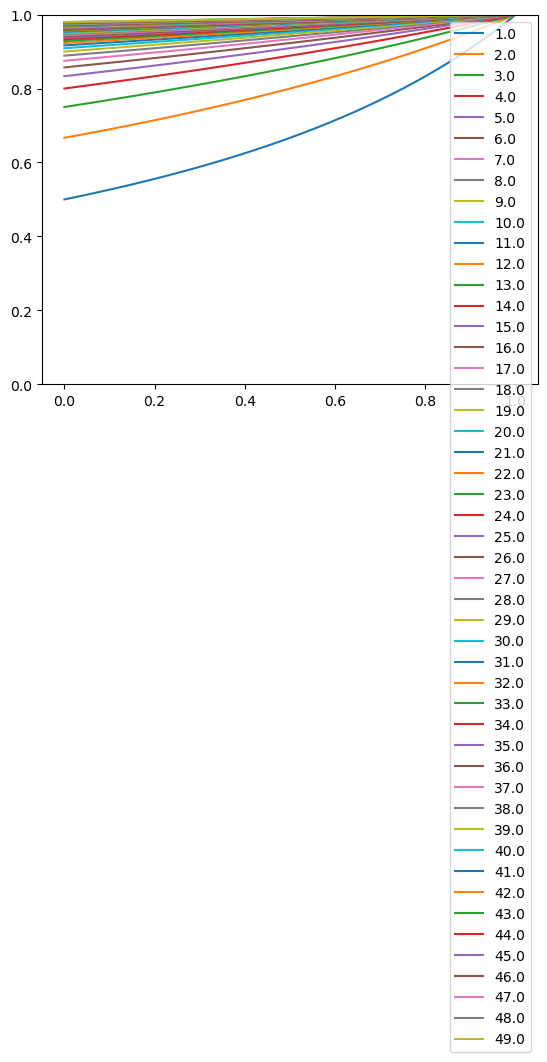

In [7]:
def fss_with_c(p, c):
    fss = 0.5 +(c - 1 + p)/(2 * (c+1-p))
    return fss
fss_dict_with_c = {n: [fss_with_c(item, c_vals[n]) for item in p] for n in range(len(c_vals))}
for n, fss_vals in fss_dict_with_c.items():
    plt.plot(p, fss_vals, label=f'{c_vals[n]:.1f}')
    plt.ylim([0, 1])
plt.legend()

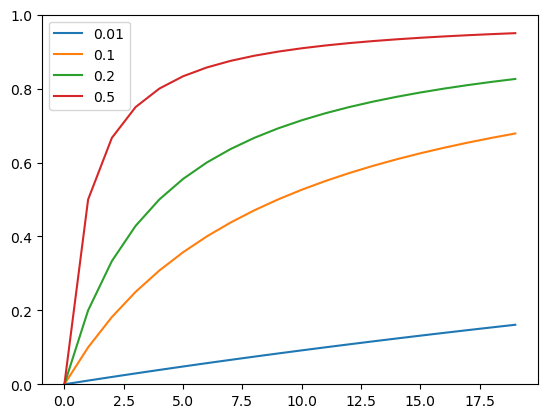

In [21]:
# The expected value at a particular window size, with zere correlation
p = 0.01

nrange = np.arange(0, 20)

for p in [0.01, 0.1, 0.2, 0.5]:
    fss_threshold = [(n*p) / (n*p -p + 1) for n in nrange]

    plt.plot(nrange, fss_threshold, label=p)
    plt.ylim([0,1])
plt.legend()

In [82]:
import pandas as pd

dates = pd.date_range(start=date(2018,3,1), end=date(2018,5,31))

In [85]:
dates[0].date()

datetime.date(2018, 3, 1)

In [87]:
import numpy as np
import os
import sys
import pickle
from pathlib import Path
from datetime import date
from tqdm import tqdm
import xarray as xr

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan import data, data_generator
# Load iMERG and IFS data

latitude_vals = np.arange(-11.95, 15.95, 0.1)
longitude_vals = np.arange(25.05, 49.05, 0.1)
dates = pd.date_range(start=date(2019,3,1), end=date(2019,5,31))
dates = [d.date() for d in dates]
hours = range(24)
obs_data = []
fcst_data = []
datetimes = []

for d in tqdm(dates):
    for hour in hours:
        
        imerg_fps = data.get_imerg_filepaths(d.year, d.month, d.day, hour=hour)
        loaddate, loadtime = data.get_ifs_forecast_time(d.year, d.month, d.day, hour=hour)


        for im_fp in imerg_fps:
            ds_imerg = data.load_imerg(date=d, hour=hour, latitude_vals=latitude_vals,
                                       longitude_vals=longitude_vals)
            # ds_imerg = xr.load_dataset(im_fp)
            # ds_imerg = ds_imerg.isel(time=0).transpose('lat', 'lon', 'nv', 'latv', 'lonv')
            # ds_imerg = data.standardise_dataset(ds_imerg)
            # ds_imerg = ds_imerg.sel(lon=longitude_vals + 1e-6, method='nearest').sel(lat=latitude_vals+1e-6, method='nearest')
            
            ds_ifs = data.load_ifs('tp', d, hour, log_precip=False, norm=False, latitude_vals=latitude_vals, longitude_vals=longitude_vals)
            
            obs_data.append(ds_imerg)
            fcst_data.append(ds_ifs)

truth_array = np.stack(obs_data, axis=0)
fcst_array = np.stack(fcst_data, axis=0)
    

with open(os.path.join(f"fss_data_{dates[0].strftime('%Y%m%d')}-{dates[-1].strftime('%Y%m%d')}.pkl"), 'wb+') as ofh:
    pickle.dump({'truth': truth_array, 'fcst': fcst_array}, ofh, pickle.HIGHEST_PROTOCOL)

  2%|▏         | 2/92 [00:36<27:43, 18.48s/it]


KeyboardInterrupt: 

In [88]:
truth_array = np.stack(obs_data, axis=0)
fcst_array = np.stack(fcst_data, axis=0)

In [91]:
import pickle
with open(os.path.join(f"fss_data_{dates[0].strftime('%Y%m%d')}-{dates[-1].strftime('%Y%m%d')}.pkl"), 'wb+') as ofh:
    pickle.dump({'truth': truth_array, 'fcst': fcst_array}, ofh, pickle.HIGHEST_PROTOCOL)

In [5]:

def calculate_fss(truth_array, fcst_array, threshold, min_window_size=1, max_window_size=50):
    
    
    (n_samples, height, width) = truth_array.shape
    fss = {}
    fractions_truth_mean = {}
    fractions_fcst_mean = {}
    
    fractions_truth_std = {}
    fractions_fcst_std = {}
    
    lower_bound = {}

    for window_size in np.arange(min_window_size, max_window_size):

        num_windows_h = int(height / window_size)
        num_windows_w = int(width / window_size)

        fractions_truth = []
        fractions_fcst = []
        for n in range(n_samples):
            
            truth_data = truth_array[n, :, :]
            fcst_data = fcst_array[n, :, :]
            
            for h_window in range(num_windows_h):
                for w_window in range(num_windows_w):
                    
                    truth_window = truth_data[h_window*window_size:(h_window+1)*window_size, w_window*window_size:(w_window+1)*window_size]
                    truth_fraction = np.nansum(truth_window > threshold) / (window_size**2)
                    fractions_truth.append(truth_fraction)
                    
                    fcst_window = fcst_data[h_window*window_size:(h_window+1)*window_size, w_window*window_size:(w_window+1)*window_size]
                    fcst_fraction = (fcst_window > threshold).sum() / (window_size**2)
                    fractions_fcst.append(fcst_fraction)
                    
        fractions_truth = np.array(fractions_truth)
        fractions_fcst = np.array(fractions_fcst)
        
        fractions_truth_mean[window_size] = fractions_truth.mean()
        fractions_fcst_mean[window_size] = fractions_fcst.mean()
        
        fractions_truth_std[window_size] = fractions_truth.std()
        fractions_fcst_std[window_size] = fractions_fcst.std()
            
        fss[window_size] = 2*(fractions_truth*fractions_fcst).sum() / (np.power(fractions_truth, 2).sum() + np.power(fractions_fcst, 2).sum())
        
        lower_bound[window_size] = 2*fractions_truth_mean[window_size]**2 / (2*fractions_truth_mean[window_size]**2 + 2*fractions_truth_std[window_size]**2 )

    return fss, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound
    



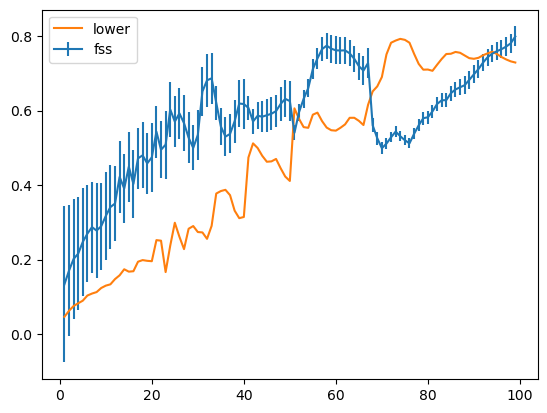

In [7]:
fss_dict, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound= calculate_fss(truth_array=truth_array, fcst_array=fcst_array, threshold=0.1, max_window_size=100)

import matplotlib.pyplot as plt

plt.errorbar(fss_dict.keys(), fss_dict.values(), yerr = list(fractions_truth_std.values()), label='fss')
plt.plot(lower_bound.keys(), lower_bound.values(), label='lower')
plt.legend()

In [55]:
from scipy.ndimage import uniform_filter

def fss_pysteps( fcst_array, obs_array, scale, thr, mode='constant'):

    """Accumulate ensemble forecast-observation pairs to an FSS object.
    Does ensemble mean of thresholded arrays.
    Parameters
    -----------

    X_f: array_like
        Array of shape (s,  m, n) containing an ensemble of c forecast fields.
    X_o: array_like
        Array of shape (s, m, n) containing the observation field.
    """
    if fcst_array.shape != obs_array.shape:
        message = "X_f and X_o must havethe same image dimensions"
        raise ValueError(message)

    sum_obs_sq = 0
    sum_fct_obs = 0
    sum_fct_sq = 0
    
    obs_filtered = []
    fcst_filtered = []

    for n in range(obs_array.shape[0]):
        X_o = truth_array[n, :, :]
        X_f = fcst_array[n, :, :]

        # Convert to binary fields with the given intensity threshold
        I_f = (X_f >= thr).astype(np.single)
        I_o = (X_o >= thr).astype(np.single)

        # Compute fractions of pixels above the threshold within a square
        # neighboring area by applying a 2D moving average to the binary fields
        if scale > 1:
            if mode == 'constant':
                S_f = uniform_filter(I_f, size=scale, mode="constant", cval=0.0)
                S_o = uniform_filter(I_o, size=scale, mode="constant", cval=0.0)
            else:
                    
                S_f = uniform_filter(I_f, size=scale, mode=mode)
                S_o = uniform_filter(I_o, size=scale, mode=mode)
            
        else:
            S_f = I_f
            S_o = I_o

        
        sum_obs_sq += np.nansum(S_o ** 2)
        sum_fct_obs += np.nansum(S_f * S_o)
        sum_fct_sq += np.nansum(S_f ** 2)
    
    numer = sum_fct_sq - 2.0 * sum_fct_obs + sum_obs_sq
    denom = sum_fct_sq + sum_obs_sq

    return 1.0 - numer / denom, S_f, S_o

In [75]:
from tqdm import tqdm

# threshold_vals = [0.01, 0.1, 0.15, 0.2, 0.25]
threshold_vals = [0.01]
window_range = range(1,200)

p_truth = []
fcst_results = {}
ensmean_results = []
random_fcsts = []
lb = {}
corr = {}

def lower_bound(mu_obs, mu_f, sigma_obs, sigma_f):
    return (2*mu_obs*mu_f)/(mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)

def correlation(fss, mu_obs, mu_f, sigma_obs, sigma_f):
    lb = (2*mu_obs*mu_f)/(mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)
    return (fss - lb) * (mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2) / (2*sigma_f*sigma_obs)

for mode in ['constant', 'reflect']:
    fcst_results[mode] = []
    lb[mode] = []
    corr[mode] = []
    
    for threshold in tqdm(threshold_vals, total=len(threshold_vals)):
        p_truth.append((truth_array > threshold).mean())
        
        fcst_result = [fss_pysteps( fcst_array, truth_array, n, threshold, mode=mode) for n in window_range]
        
        fcst_results[mode].append(fcst_result)
    # ensmean_results.append([fss_pysteps( samples_ensmean_array, truth_array, n, threshold) for n in window_range])

        fcst_mu = {n: fcst_result[ix][1].mean() for ix, n in enumerate(window_range)}
        fcst_sigma = {n: fcst_result[ix][1].std() for ix, n in enumerate(window_range)}

        obs_mu = {n: fcst_result[ix][2].mean() for ix, n in enumerate(window_range)}
        obs_sigma = {n: fcst_result[ix][2].std() for ix, n in enumerate(window_range)}
        
        lb[mode].append([lower_bound(obs_mu[n], fcst_mu[n], obs_sigma[n], fcst_sigma[n]) for n in window_range])
        corr[mode].append([correlation(fcst_result[n-1][0], obs_mu[n], fcst_mu[n], obs_sigma[n], fcst_sigma[n]) for n in window_range])

100%|██████████| 1/1 [01:50<00:00, 110.68s/it]


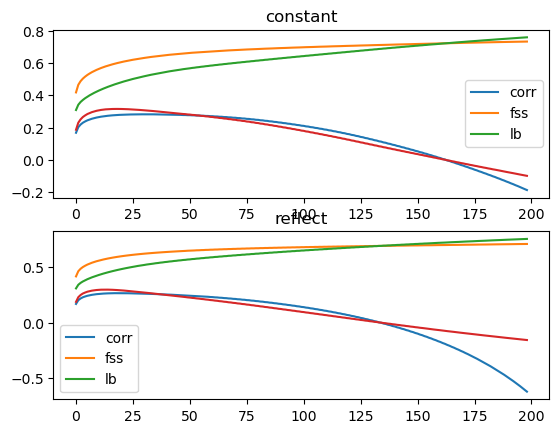

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
for p_n, threshold in enumerate(threshold_vals):
    
    for n, mode in enumerate(['constant', 'reflect']):
        axs[n].plot(corr[mode][p_n], label='corr')
        axs[n].plot([item[0] for item in fcst_results[mode][p_n]], label='fss')
        axs[n].plot([item for item in lb[mode][p_n]], label='lb')
        fcst_fss = [item[0] for item in fcst_results[mode][p_n]]
        axs[n].plot([(fcst_fss[m] - lb[mode][p_n][m]) / (1-fcst_fss[m]) for m in range(len(fcst_fss))])
        axs[n].set_title(mode)
        axs[n].legend()
#     axs[p_n].plot(corr[p_n])
#     # axs[p_n].plot([fcst_fss[m] - lb[p_n][m] for m in range(len(fcst_fss))])
#     # axs[p_n].plot(fcst_fss, label='ifs')

    # axs[p_n].plot([item[0] for item in fcst_results[p_n]], label='ifs')
#     # axs[p_n].plot([item[0] for item in ensmean_results[p_n]], label='cGAN ensemble')
#     # axs[p_n].plot([0.5 + 0.05/2]*len(fcst_results[p_n]))
    
    
#     # axs[p_n].plot(lb[p_n], label='lb')
#     # axs[p_n].plot(lb_2[p_n], '--', label='lb2')
#     # axs[p_n].plot([(p_truth[p_n])/(1+p_truth[p_n])]*len(fcst_results[p_n]), label='uniform')
#     # plt.plot()
#     axs[p_n].legend()

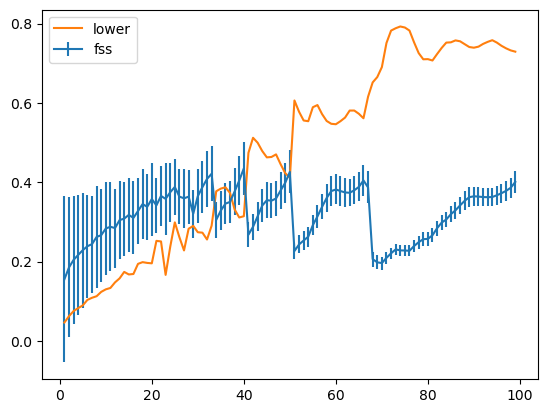

In [44]:
fss_dict, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound= calculate_fss(truth_array=truth_array, fcst_array=samples_ensmean_array, threshold=0.1, max_window_size=100)

import matplotlib.pyplot as plt

plt.errorbar(fss_dict.keys(), fss_dict.values(), yerr = list(fractions_truth_std.values()), label='fss')
plt.plot(lower_bound.keys(), lower_bound.values(), label='lower')
plt.legend()

In [77]:
# Correlations at pixel level
from scipy.stats import pearsonr
from tqdm import tqdm

threshold = 0.01
(n_samples, height, width) = truth_array.shape
var_t = {}
var_f = {}
corr_tn_t = {}
corr_fn_t = {}
corr_fn_f = {}

for n in tqdm([1,2,3,4,5, 7, 10, 15, 20, 25, 40, 60, 100, 120]):

    t = []
    f = []
    tn = []
    fn = []
    
    for h in np.arange(1, height):
        for w in np.arange(1, width-n):

            t0 = (truth_array[:, h, w] >= threshold).astype(np.single)
            tn_y = (truth_array[:, h, w+n] >= threshold).astype(np.single)
            
            f0 = (fcst_array[:, h, w]>= threshold).astype(np.single)
            fn_y = (fcst_array[:, h, w+n]>= threshold).astype(np.single)
                        
            t += [t0]
            tn += [tn_y]
            
            f += [f0]
            fn += [fn_y]
            
    for w in np.arange(1, width):
        for h in np.arange(1, height-n):
        

            t0 = (truth_array[:, h, w] >= threshold).astype(np.single)
            tn_x = (truth_array[:, h+n, w] >= threshold).astype(np.single)
            
            f0 = (fcst_array[:, h, w]>= threshold).astype(np.single)
            fn_x = (fcst_array[:, h+n, w]>= threshold).astype(np.single)
                        
            t += [t0]
            tn += [tn_x]
            
            f += [f0]
            fn += [fn_x]
            
    t_array = np.stack(t, axis=0)
    tn_array = np.stack(tn, axis=0)
    
    f_array = np.stack(f, axis=0)
    fn_array = np.stack(fn, axis=0)
    
    var_t[n] = t_array.var()
    var_f[n] = f_array.var()
    corr_tn_t[n] = pearsonr(t_array.flatten(), tn_array.flatten()).statistic
    corr_fn_t[n] = pearsonr(t_array.flatten(), fn_array.flatten()).statistic
    corr_fn_f[n] = pearsonr(f_array.flatten(), fn_array.flatten()).statistic

100%|██████████| 14/14 [02:05<00:00,  8.97s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


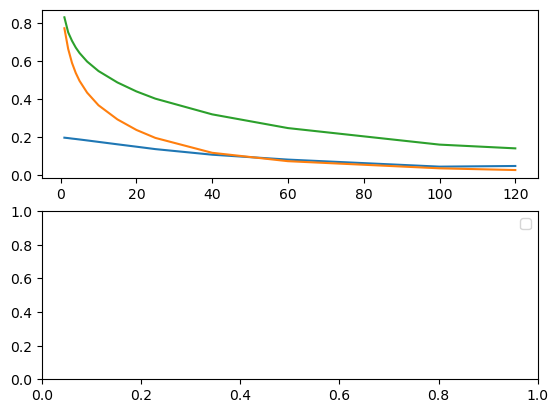

In [80]:
import matplotlib.pyplot as plt
from scipy.stats import expon 
fig, ax = plt.subplots(2, 1)

# Fit exponential function
import numpy as np
from sklearn.linear_model import LinearRegression

# X = np.array(list(corr_tn_t.keys())).reshape(-1, 1)
# y_t = np.log(list(corr_tn_t.values()))
# y_f = np.log(list(corr_fn_f.values()))

# reg_t = LinearRegression().fit(X, y_t)
# reg_f = LinearRegression().fit(X, y_f)

ax[0].plot(corr_fn_t.keys(), corr_fn_t.values(), label='fn_t')
ax[0].plot(corr_tn_t.keys(), corr_tn_t.values(), label='tn_t')
ax[0].plot(corr_fn_f.keys(), corr_fn_f.values(), label='tn_t')

# ax[1].plot(corr_tn_t.keys(), np.log(list(corr_tn_t.values())), label='tn_t')
# ax[1].plot(corr_fn_f.keys(), np.log(list(corr_fn_f.values())), label='fn_f')
# ax[1].plot(corr_tn_t.keys(), reg_t.intercept_ + reg_t.coef_*X, '+')
# ax[1].plot(corr_fn_f.keys(), reg_f.intercept_ + reg_f.coef_*X, '+')

ax[1].legend()

In [132]:
# Plots of error functions
from scipy.special import erfc
from scipy.stats import norm

sigma = 20
mu = 20
alpha = -reg_f.coef_
beta = 1
max_val = beta * np.sqrt(2) * np.exp(0.5 * sigma**2 * alpha**2) * erfc(alpha*sigma / np.sqrt(2))
n_list = np.arange(2, 50)

integral_vals = []
integral_vals_2 = []
errf_vals = []
Z_vals = []
A_vals = []
approx_vals = []
approx_vals_2 = []
for n in n_list:
    
    Z = (alpha*sigma**2 - (mu - n))/(sigma * np.sqrt(2))
    A = beta *np.exp(0.5 * (sigma**2)*(alpha**2) - alpha * mu + alpha*n) / np.sqrt(2)
    
    Z_2 = (alpha*sigma**2 + (mu - n))/(sigma * np.sqrt(2))
    A_2 = beta *np.exp(0.5 * (sigma**2)*(alpha**2) + alpha * mu - alpha*n) / np.sqrt(2)
    
    integral_vals.append(A * erfc(Z))
    integral_vals_2.append(A_2 * erfc(Z_2))
    errf_vals.append(erfc(Z))
    A_vals.append(A)
    Z_vals.append(Z)
    
    # Normal approximation
    mu_approx = mu
    var = sigma**2 + 1 /(alpha**2)
    approx_vals.append(norm.pdf(n, loc=mu, scale=np.sqrt(var)))
    
    approx_vals_2.append(beta* np.sqrt(2 * np.pi * sigma**2) * np.exp( - (mu - n)**2 / (2 * sigma**2)) / ( 1 + (mu - n) / ((sigma**2) * alpha)))
integral_vals = np.array(integral_vals)
integral_vals_2 = np.array(integral_vals_2)

total_integral_vals = integral_vals + integral_vals_2

approx_vals = np.array(approx_vals)
approx_vals = approx_vals *(max_val) * np.sqrt(2 * np.pi * sigma**2)


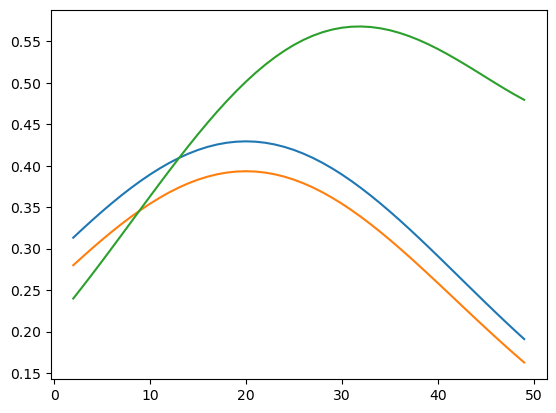

In [136]:
fig, ax = plt.subplots(1, 1)

ax.plot(n_list, np.array(integral_vals_2) + np.array(integral_vals))
ax.plot(n_list, approx_vals)
ax.plot(n_list, np.array(approx_vals_2) / 100)

In [107]:
np.sum(approx_vals)

17.613869801736353

In [108]:
np.sum(integral_vals + integral_vals_2)

20.112134841201378

In [7]:
from scipy.stats import expon

ax.plot(expon.pdf(range(20)), 'r-', lw=5, alpha=0.6, label='expon pdf')

(loc, scale) = expon.fit(list(corr_tn_t.values()))

(0.05270488101559383, 0.13390881591912934)

In [44]:


threshold = 0.01
modes = ['reflect', 'constant', 'nearest', 'mirror', 'wrap']
(n_samples, height, width) = truth_array.shape
paired_fractions = {}

corr = {}
pixel_vals = {}
for mode in modes:
    print(mode)
    corr[mode] = {}
    pixel_vals[mode] = {}
    for window_size in tqdm([180]):

        paired_fractions[window_size] = []
        convolved_obs = []
        convolved_fcst = []
        
        indexer = []
        for row_num in range(height - window_size + 1):
            for col_num in range(width - window_size + 1):
                indexer.append([list(np.arange(col_num + (n+ row_num)*width, col_num + (n+ row_num)*width + window_size)) for n in range(window_size)])
        
        for n in range(n_samples):
            
            truth_data = truth_array[n, :, :]
            fcst_data = fcst_array[n, :, :]
            
            fcst_int = (fcst_data >= threshold).astype(np.single)
            obs_int = (truth_data >= threshold).astype(np.single)
            
            
            if window_size > 1:
                if mode == 'constant':
                    S_f = uniform_filter(fcst_int, size=window_size, mode="constant", cval=0)
                    S_o = uniform_filter(obs_int, size=window_size, mode="constant", cval=0)
                elif mode == 'constant_mode':
                    S_f = uniform_filter(fcst_int, size=window_size, mode="constant", cval=0)
                    S_o = uniform_filter(obs_int, size=window_size, mode="constant", cval=0)
                elif mode == 'shrink':
                    S_f = fcst_int.flatten()[indexer].mean(axis=(1,2)).reshape(height - window_size+1,width - window_size+1)
                    S_o = obs_int.flatten()[indexer].mean(axis=(1,2)).reshape(height - window_size+1,width - window_size+1)
                    
                    # S_f = np.empty((height - (window_size -1), width  - (window_size -1)))
                    # S_o = np.empty((height - (window_size -1), width  - (window_size -1)))
                    # S_f[:] = np.nan
                    # S_o[:] = np.nan
                    # for h_window in range(height - (window_size -1)):
                    #     for w_window in range(width  - (window_size -1)):
                            
                    #         truth_window = obs_int[h_window:h_window + window_size, w_window: w_window + window_size]
                    #         truth_fraction = truth_window.mean()
                            
                    #         S_o[h_window, w_window] = truth_fraction
                            
                    #         fcst_window = fcst_int[h_window:h_window + window_size, w_window: w_window + window_size]
                    #         fcst_fraction = fcst_window.mean()
                            
                    #         S_f[h_window, w_window] = fcst_fraction
                            
                else:
                    
                    S_f = uniform_filter(fcst_int, size=window_size, mode=mode)
                    S_o = uniform_filter(obs_int, size=window_size, mode=mode)
            else:
                S_f = fcst_data
                S_o = truth_data
            convolved_obs.append(S_o)
            convolved_fcst.append(S_f)
        conv_obs_array = np.stack(convolved_obs, axis=0)
        conv_fcst_array = np.stack(convolved_fcst, axis=0)

        corr[mode][window_size] = pearsonr(conv_obs_array.flatten(), conv_fcst_array.flatten())
        pixel_vals[mode][window_size] = conv_obs_array.mean(axis=0)
    

reflect


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


constant


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


nearest


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


mirror


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


wrap


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


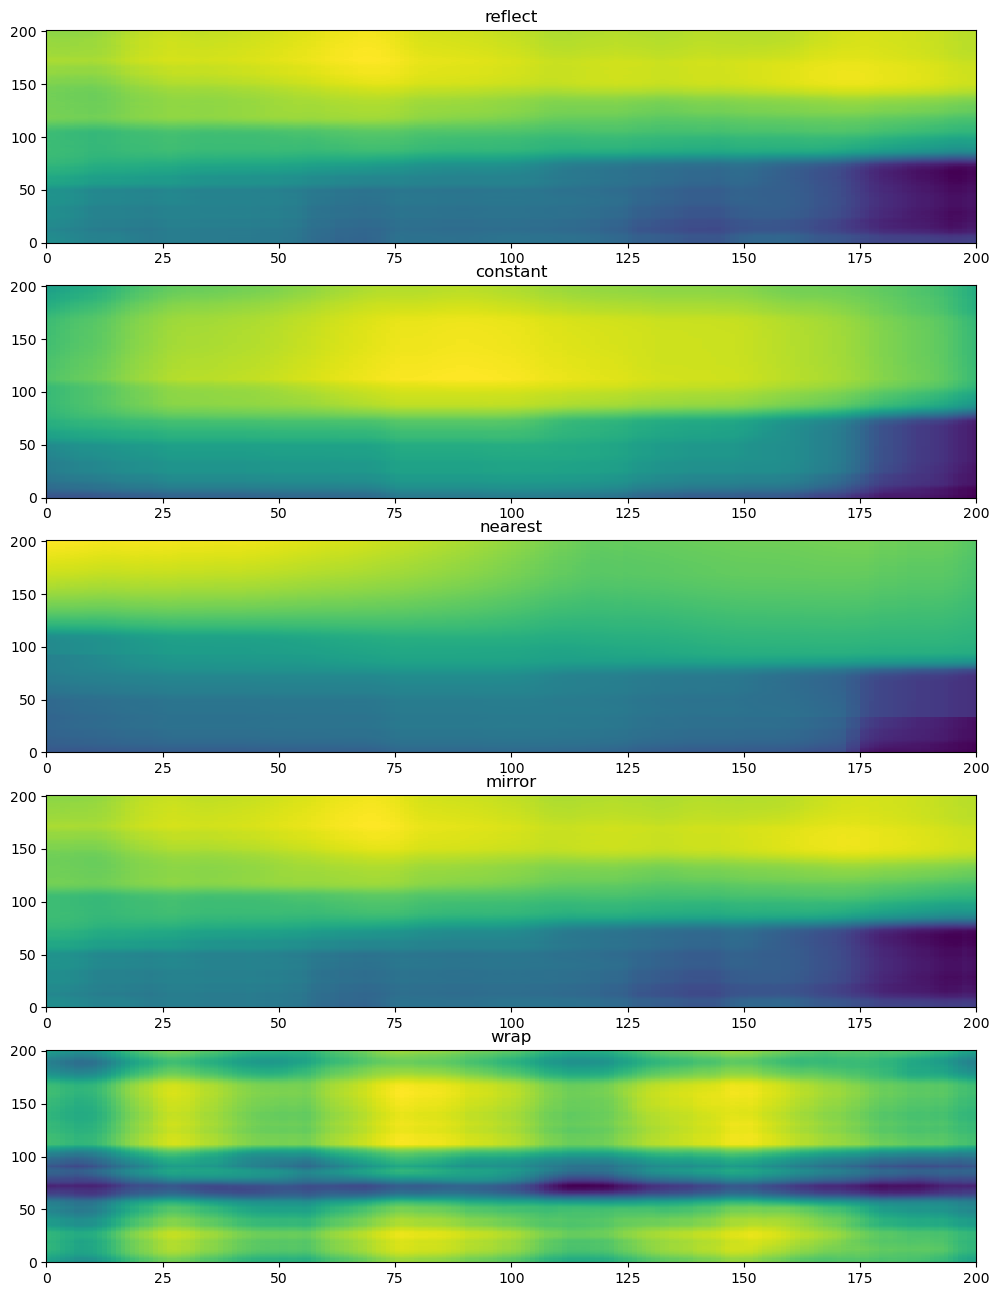

In [46]:
m=180
max_val = max([np.log(pixel_vals[mode][m]).max() for mode in modes])
min_val = min([np.log(pixel_vals[mode][m]).max() for mode in modes])

fig, ax = plt.subplots(len(modes), 1, figsize=(12,16))
for n, mode in enumerate(modes):
    ax[n].pcolormesh(np.log(pixel_vals[mode][m]))
    ax[n].set_title(mode)

reflect
constant
nearest
mirror
wrap
shrink


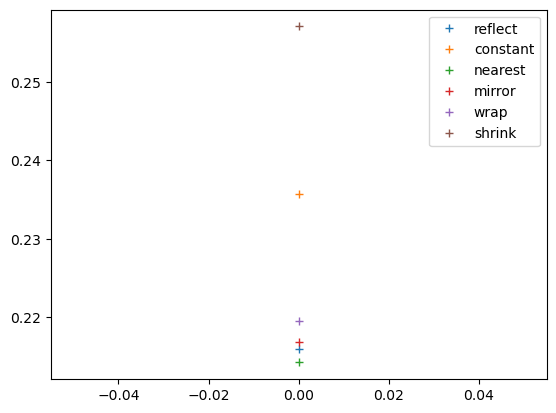

In [132]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

for mode, vals in corr.items():
    print(mode)
    ax.plot([item.statistic for item in vals.values()], '+', label=mode)
ax.legend()

In [62]:
from numpy.lib.stride_tricks import sliding_window_view

a = np.arange(100).reshape((10,10))

a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [74]:
from itertools import chain
num_cols = 10
indexer = []
window_size = 5
indexer = [list(chain.from_iterable([list(np.arange(n*num_cols, n*num_cols + window_size)) for n in range(window_size)])) for 


In [121]:
m = 10
num_cols = 10
num_rows = 10
indexer = []
for row_num in range(num_rows - window_size + 1):
    for col_num in range(num_cols - window_size + 1):
        indexer.append([list(np.arange(col_num + (n+ row_num)*num_cols, col_num + (n+ row_num)*num_cols + window_size)) for n in range(window_size)])
# [[list(np.arange(m - (m // num_cols) + (n+ m // num_cols)*num_cols, m - (m // num_cols) + (n+ m // num_cols)*num_cols + window_size)) for n in range(window_size)] for m in range(num_cols - window_size + 1)]

In [126]:
a.flatten()[indexer].mean(axis=(1,2)).reshape(6,6)

array([[22., 23., 24., 25., 26., 27.],
       [32., 33., 34., 35., 36., 37.],
       [42., 43., 44., 45., 46., 47.],
       [52., 53., 54., 55., 56., 57.],
       [62., 63., 64., 65., 66., 67.],
       [72., 73., 74., 75., 76., 77.]])

In [93]:
30 // num_cols

3

In [84]:
3

3